In [279]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

import graphviz
import pydotplus

import pandas as pd
import numpy as np
import scipy as sp

from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from IPython.display import Image

pd.options.display.max_columns = 25
pd.options.display.max_rows = None

# Загрузка и предварительная обработка данных

In [280]:
def heatmap(values, xlabel, ylabel, xticklabels, yticklabels, cmap=None,
            vmin=None, vmax=None, ax=None, fmt="%0.2f"):
    if ax is None:
        ax = plt.gca()
    # plot the mean cross-validation scores
    img = ax.pcolor(values, cmap=cmap, vmin=vmin, vmax=vmax)
    img.update_scalarmappable()
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xticks(np.arange(len(xticklabels)) + .5)
    ax.set_yticks(np.arange(len(yticklabels)) + .5)
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)
    ax.set_aspect(1)

    for p, color, value in zip(img.get_paths(), img.get_facecolors(),
                               img.get_array()):
        x, y = p.vertices[:-2, :].mean(0)
        if np.mean(color[:3]) > 0.5:
            c = 'k'
        else:
            c = 'w'
        ax.text(x, y, fmt % value, color=c, ha="center", va="center")
    return img

In [281]:
def binary_weather(df):
    if df['Events'] == 'clear':
        return 1
    return 0

In [282]:
df_austin = pd.read_csv("austin_weather.csv")
df_austin[['Events', 'Date']].groupby(['Events']).count()

,Date
Events,
,903
Fog,21
"Fog , Rain",14
"Fog , Rain , Thunderstorm",33
"Fog , Thunderstorm",1
Rain,192
"Rain , Snow",1
"Rain , Thunderstorm",137
Thunderstorm,17


In [283]:
df_austin = df_austin[
    (df_austin.Events != 'Fog , Thunderstorm') & (df_austin.Events != 'Rain , Snow')]
df_austin['Events'].replace(' ', np.nan, inplace=True)
df_austin['Events'].fillna('clear', inplace=True)
df_austin['PrecipitationSumInches'].replace('T', 0, inplace=True)
df_austin.replace('-', np.nan, inplace=True)
df_austin.dropna(inplace=True)
df_austin['PrecipitationSumInches'] = df_austin.PrecipitationSumInches.astype('float')

In [284]:
df_austin['Binary'] = df_austin.apply(binary_weather, axis=1)
df_austin[['Binary', 'Date']].groupby(['Binary']).count()

,Date
Binary,
0,411
1,892


In [285]:
le = LabelEncoder()
le.fit(df_austin['Events'])
df_austin["MultiTarget"] = le.transform(df_austin['Events'])

df_austin['DewPointHighF'] = df_austin['DewPointHighF'].astype('int')
df_austin['DewPointAvgF'] = df_austin['DewPointAvgF'].astype('int')
df_austin['DewPointLowF'] = df_austin['DewPointLowF'].astype('int')

df_austin['HumidityHighPercent'] = df_austin['HumidityHighPercent'].astype('int')
df_austin['HumidityAvgPercent'] = df_austin['HumidityAvgPercent'].astype('int')
df_austin['HumidityLowPercent'] = df_austin['HumidityLowPercent'].astype('int')

df_austin['SeaLevelPressureHighInches'] = df_austin['SeaLevelPressureHighInches'].astype('float')
df_austin['SeaLevelPressureLowInches'] = df_austin['SeaLevelPressureLowInches'].astype('float')
df_austin['SeaLevelPressureLowInches'] = df_austin['SeaLevelPressureLowInches'].astype('float')

df_austin['VisibilityHighMiles'] = df_austin['VisibilityHighMiles'].astype('int')
df_austin['VisibilityAvgMiles'] = df_austin['VisibilityAvgMiles'].astype('int')
df_austin['VisibilityLowMiles'] = df_austin['VisibilityLowMiles'].astype('int')

df_austin['WindHighMPH'] = df_austin['WindHighMPH'].astype('int')
df_austin['WindAvgMPH'] = df_austin['WindAvgMPH'].astype('int')
df_austin['WindGustMPH'] = df_austin['WindGustMPH'].astype('int')

In [286]:
df_austin.corr()

,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,SeaLevelPressureHighInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Binary,MultiTarget
TempHighF,1.000000,0.970921,0.881748,0.810057,0.806344,0.763400,0.138914,-0.108956,-0.250105,-0.674904,-0.532044,0.100760,0.293961,0.202427,0.023603,-0.002326,0.040213,-0.068567,0.184376,0.212413
TempAvgF,0.970921,1.000000,0.968700,0.880987,0.894644,0.863612,0.211604,0.033078,-0.088978,-0.693255,-0.535798,0.091603,0.209089,0.111020,0.024901,0.041091,0.038444,-0.018526,0.091064,0.131117
TempLowF,0.881748,0.968700,1.000000,0.901441,0.931991,0.914891,0.274537,0.178559,0.083553,-0.670120,-0.507575,0.075225,0.108104,0.008557,0.026066,0.082932,0.035154,0.036332,-0.012329,0.037781
DewPointHighF,0.810057,0.880987,0.901441,1.000000,0.965963,0.894764,0.523472,0.412108,0.264576,-0.703924,-0.605702,0.048984,-0.061573,-0.188255,0.106266,0.081042,0.117601,0.138022,-0.168535,-0.123893
DewPointAvgF,0.806344,0.894644,0.931991,0.965963,1.000000,0.966644,0.533359,0.454251,0.319602,-0.692489,-0.546439,0.047755,-0.065607,-0.179800,0.041418,0.041616,0.051615,0.127318,-0.158277,-0.115770
DewPointLowF,0.763400,0.863612,0.914891,0.894764,0.966644,1.000000,0.491121,0.460909,0.356773,-0.646246,-0.459851,0.042558,-0.036715,-0.147171,-0.026830,0.003176,-0.020718,0.125855,-0.134170,-0.091987
HumidityHighPercent,0.138914,0.211604,0.274537,0.523472,0.533359,0.491121,1.000000,0.824189,0.558060,-0.294802,-0.253796,-0.045361,-0.431653,-0.527638,0.000107,-0.088875,-0.006923,0.228612,-0.383866,-0.382690
HumidityAvgPercent,-0.108956,0.033078,0.178559,0.412108,0.454251,0.460909,0.824189,1.000000,0.928265,-0.188392,-0.158477,-0.103338,-0.586244,-0.640491,0.012082,-0.001053,0.006172,0.346986,-0.535573,-0.525977
HumidityLowPercent,-0.250105,-0.088978,0.083553,0.264576,0.319602,0.356773,0.558060,0.928265,1.000000,-0.083384,-0.066164,-0.122429,-0.577028,-0.594133,0.016057,0.056513,0.013105,0.360482,-0.534787,-0.521909
SeaLevelPressureHighInches,-0.674904,-0.693255,-0.670120,-0.703924,-0.692489,-0.646246,-0.294802,-0.188392,-0.083384,1.000000,0.904735,-0.046279,0.033818,0.102828,-0.148130,-0.118391,-0.180780,-0.108865,0.058894,0.028755


In [287]:
features = [
     'PrecipitationSumInches', 
     'VisibilityLowMiles',
     'VisibilityAvgMiles'
]

# Бинарная классификация

In [288]:
X_train, X_test, y_train, y_test = train_test_split(
    df_austin[features],
    df_austin['Binary'],
    random_state=0
) 

tree_class = tree.DecisionTreeClassifier(
    random_state=42, max_depth=3,
    criterion='entropy', max_features=len(features)
)

tree_class.fit(X_train, y_train)
print("Правильность на обучающем наборе: {:.3f}".format(tree_class.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.3f}".format(tree_class.score(X_test, y_test)))

Правильность на обучающем наборе: 0.930
Правильность на тестовом наборе: 0.945


In [289]:
for i, j in zip(features, tree_class.feature_importances_):
    print(f"{i} - {j * 100:.2f}")

PrecipitationSumInches - 84.03
VisibilityLowMiles - 14.85
VisibilityAvgMiles - 1.12


Text(0.5, 1.0, 'Оценка значимости признаков')

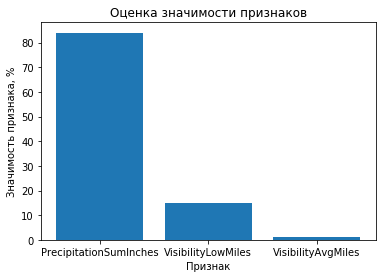

In [290]:
plt.bar(features, tree_class.feature_importances_*100)
plt.ylabel("Значимость признака, %")
plt.xlabel("Признак")
plt.title("Оценка значимости признаков")

In [291]:
cross = cross_val_score(tree_class, df_austin[features], df_austin['Binary'], cv=5)
print(cross)
print(np.mean(cross))

[0.92366412 0.95785441 0.90769231 0.94615385 0.92307692]
0.9316883210381499


In [292]:
pred_binary = tree_class.predict(X_test)
print(confusion_matrix(y_test, pred_binary))

[[ 81  17]
 [  1 227]]


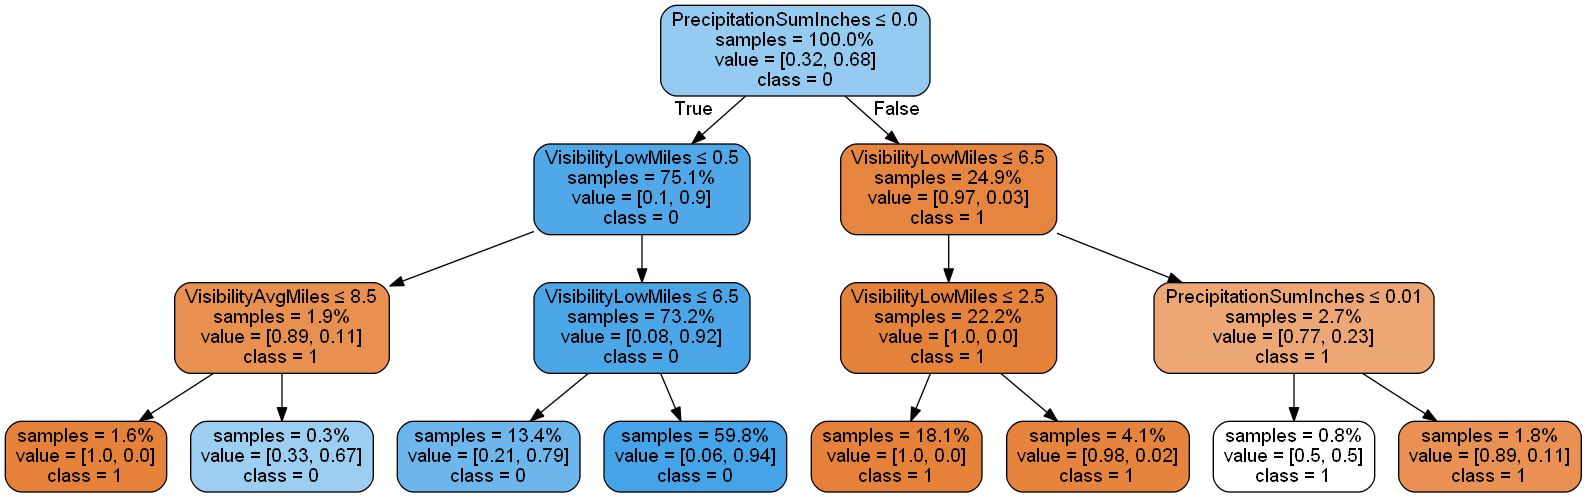

In [293]:
dot_data = tree.export_graphviz(decision_tree=tree_class, out_file="tree.out",
                                max_depth=5,
                                feature_names=features,
                                class_names=['1', '0'],
                                filled=True, rounded=True,  
                                special_characters=True,
                                proportion = True, precision=2,
                                label='all', impurity=False,
)  

graph = pydotplus.graphviz.graph_from_dot_file("tree.out")
Image(graph.create_png())

# Многоклассова классификация

In [294]:
features = [
     'PrecipitationSumInches', 
     'VisibilityLowMiles'
]

In [295]:
X_train, X_test, y_train, y_test = train_test_split(
    df_austin[features], df_austin['MultiTarget'],
    random_state=0
)

tree_multi = tree.DecisionTreeClassifier(
    random_state=0, max_depth=4, 
    criterion='entropy'
)

tree_multi.fit(X_train, y_train)
print("Правильность на обучающем наборе: {:.3f}".format(tree_multi.score(X_train, y_train)))
print("Правильность на тестовом наборе: {:.3f}".format(tree_multi.score(X_test, y_test)))

Правильность на обучающем наборе: 0.858
Правильность на тестовом наборе: 0.887


In [296]:
cross = cross_val_score(tree_multi, df_austin[features], df_austin['MultiTarget'], cv=5)
print(cross)
print(np.mean(cross))

[0.84030418 0.86311787 0.86153846 0.85328185 0.84496124]
0.8526407216724662


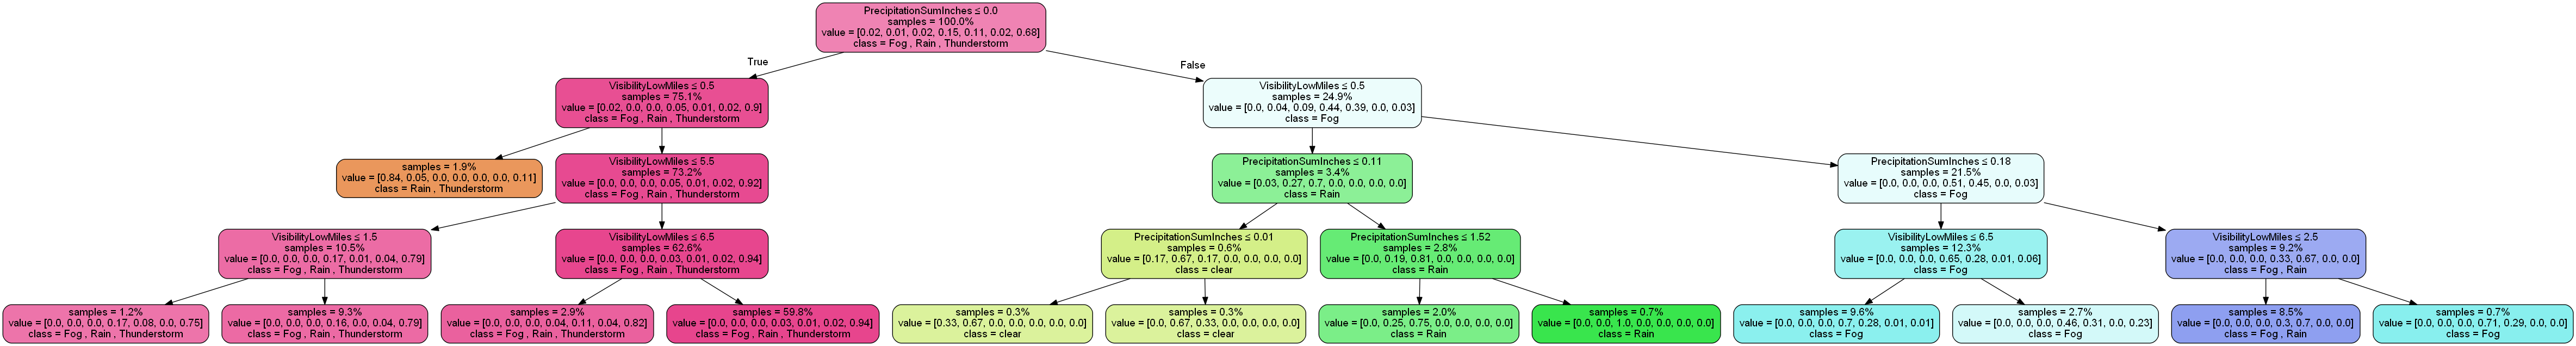

In [297]:
dot_data = tree.export_graphviz(decision_tree=tree_multi, out_file="tree.out",
                                max_depth=5,
                                feature_names=features,
                                class_names=df_austin.Events.unique(),
                                filled=True, rounded=True,  
                                special_characters=True,
                                proportion = True, precision=2,
                                label='all', impurity=False,
)  

graph = pydotplus.graphviz.graph_from_dot_file("tree.out")
Image(graph.create_png())

In [298]:
for i, j in zip(features, tree_multi.feature_importances_):
    print(i, j*100)

PrecipitationSumInches 67.12123247138348
VisibilityLowMiles 32.87876752861652


In [299]:
df = pd.DataFrame({
    "Name": df_austin.Events.unique(),
    "Code": df_austin.MultiTarget.unique()}
)

In [300]:
df

,Name,Code
0,"Rain , Thunderstorm",4
1,clear,6
2,Rain,3
3,Fog,0
4,"Fog , Rain",1
5,Thunderstorm,5
6,"Fog , Rain , Thunderstorm",2


In [301]:
df.sort_values(by="Code", inplace=True)

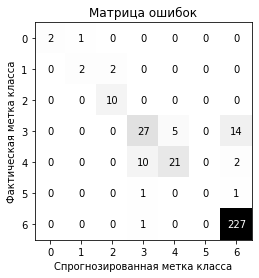

In [302]:
pred = tree_multi.predict(X_test)
# print(confusion_matrix(y_test, pred))

scores_image = heatmap(
    confusion_matrix(y_test, pred), xlabel='Спрогнозированная метка класса',
    ylabel='Фактическая метка класса', xticklabels=df.Code,
    yticklabels=df.Code, cmap=plt.cm.gray_r, fmt="%d"
)
plt.title("Матрица ошибок")
plt.gca().invert_yaxis()